# Redes sociais - P1
Fernando Fincatti, Gabriela Moreno, Gabriella Cukier e Manuel Castanares

---

### Importando bibliotecas
---

In [1]:
import netpixi
from netpixi.data.gt import *
import cpnet
from graph_tool import spectral
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
sns.set()
from matplotlib import rcParams
import statsmodels.formula.api as smf
import csv
import pandas as pd
from graph_tool import util
from graph_tool import Graph
from utils import *
from graph_tool import clustering

import seaborn as sns
sns.set()

# Análise ANTES da década de 1990

### Carrega dados
---

In [2]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [3]:
#junta ambas as tabelas
df_merge_original=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge_original=df_merge_original.dropna(subset=['region'])

In [4]:
#filtra somente datas posteriores a 1970
df_merge_before=df_merge_original[df_merge_original["Year"] >= 1970]
df_merge_before=df_merge_before[df_merge_before["Year"] <= 1990]

### Análise
---

In [5]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [6]:
df_merge_before['desempenho'] = df_merge_before['Medal'].apply(lambda x: desempenho(x))

#dropa valores duplicados
df_desempenho = df_merge_before.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])


In [7]:
df_desempenho_pais.head()

,Sport,region,desempenho,media,Country,GDP ($ per capita)
0,Alpine Skiing,Czech Republic,1,1.50,Czech Republic,15700.0
1,Alpine Skiing,Switzerland,2,1.50,Switzerland,32700.0
2,Archery,Finland,1,2.25,Finland,27400.0
3,Archery,Japan,2,2.25,Japan,28200.0
4,Archery,Russia,3,2.25,Russia,8900.0


In [8]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

lista_vertices = lista_teams+lista_eventos

#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

create_edgs_links(lista_arestas, g)

número de vértices de g: 91


### Análise 2
---

In [9]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

cria_nome_times(g, c) #cria vertíces

dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [10]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

save_gt(c, 'exemplo_c.net.gz')

r = netpixi.render('./exemplo_c.net.gz', infinite=True)

In [11]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x05445E, size=15)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0xB1D4E0, width=1, curve1=0, curve2=0)

r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)




### Cluster coefficient
---

In [12]:
cluster = clustering.local_clustering(c)

c.vp['clustering coefficient'] = cluster

dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [13]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)
        
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

save_gt(g, 'exemplo.net.gz')

r = netpixi.render('./exemplo.net.gz')

In [14]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

r.graph(kscale=0.5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Regressão
---

### GDP X Desempenho

In [15]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()


In [16]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")


In [17]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")


In [18]:
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']
df_desempenho_pais_total['pop'] = df_desempenho_pais_total['Population']

In [19]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.154
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.288
Time:                        01:28:34   Log-Likelihood:                -225.86
No. Observations:                  51   AIC:                             455.7
Df Residuals:                      49   BIC:                             459.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7016      4.621      1.883      0.066      -0.584      17.987
y              0.0003      0.000      1.074      0.288      -0.000       0.001
==============================================================================
Omnibus:                       78.476   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              992.044
Skew:                           4.179   Prob(JB):                    3.80e-216
Kurtosis:                      22.924   Cond. No.                     2.93e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

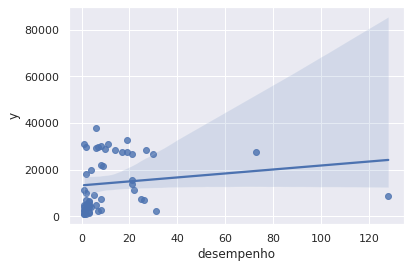

In [20]:
sns.regplot(x=df_desempenho_pais_total['desempenho'], y=(df_desempenho_pais_total['y']))
plt.show()

### GDP X Desempenho após filtragem

In [21]:
df_desempenho_pais_total[df_desempenho_pais_total['desempenho']>60]

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
16,Germany,73,Germany,27600.0,Germany,-1.979837,7.812384,0.532428,Germany,82422299.0,27600.0,0.532428,82422299.0
42,Russia,128,Russia,8900.0,Russia,-1.858927,6.989967,0.547511,Russia,142893540.0,8900.0,0.547511,142893540.0
52,USA,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<60]


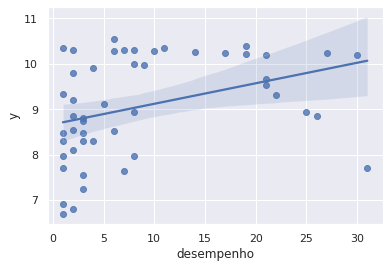

In [23]:
sns.regplot(x=df_desempenho_pais_filtered['desempenho'], y=np.log(df_desempenho_pais_filtered['y']))
plt.show()

In [24]:
model = smf.ols(data=df_desempenho_pais_filtered, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.436
Date:                Sat, 27 Nov 2021   Prob (F-statistic):             0.0241
Time:                        01:28:35   Log-Likelihood:                -173.86
No. Observations:                  49   AIC:                             351.7
Df Residuals:                      47   BIC:                             355.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4825      1.938      2.830      0.007       1.585       9.380
y              0.0002      0.000      2.332      0.024    3.39e-05       0.000
==============================================================================
Omnibus:                       13.020   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.809
Skew:                           1.253   Prob(JB):                      0.00100
Kurtosis:                       3.697   Cond. No.                     2.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Clustering Coefficient X Desempenho 

In [25]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [26]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     44.85
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.95e-08
Time:                        01:28:35   Log-Likelihood:                -209.88
No. Observations:                  51   AIC:                             423.8
Df Residuals:                      49   BIC:                             427.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.7768     12.456      7.609      0.000      69.745     119.808
c            -97.7041     14.588     -6.697      0.000    -127.021     -68.388
==============================================================================
Omnibus:                       76.216   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1020.160
Skew:                           3.931   Prob(JB):                    2.99e-222
Kurtosis:                      23.452   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

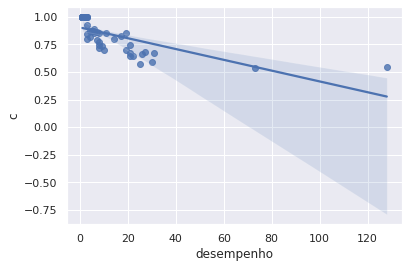

In [27]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

### Clustering Coefficient X Desempenho após filtragem

In [28]:
df_desempenho_cluster = df_desempenho_pais_filtered.dropna(subset=['clustering coefficient'])

In [29]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     132.6
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           2.79e-15
Time:                        01:28:35   Log-Likelihood:                -143.70
No. Observations:                  49   AIC:                             291.4
Df Residuals:                      47   BIC:                             295.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.4336      4.260     13.482      0.000      48.863      66.004
c            -56.7575      4.929    -11.514      0.000     -66.674     -46.841
==============================================================================
Omnibus:                        0.486   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.112
Skew:                           0.098   Prob(JB):                        0.946
Kurtosis:                       3.126   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

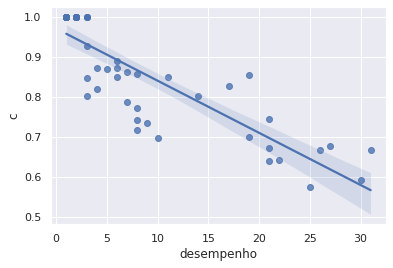

In [30]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

In [31]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     42.63
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           3.31e-13
Time:                        01:28:36   Log-Likelihood:                -143.56
No. Observations:                  49   AIC:                             295.1
Df Residuals:                      45   BIC:                             302.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.0810      5.036     11.335      0.000      46.938      67.224
y           6.724e-06   6.38e-05      0.105      0.916      -0.000       0.000
c            -56.3262      5.382    -10.466      0.000     -67.166     -45.487
pop        -1.354e-09   2.93e-09     -0.463      0.646   -7.25e-09    4.54e-09
==============================================================================
Omnibus:                        0.509   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.100
Skew:                           0.078   Prob(JB):                        0.951
Kurtosis:                       3.158   Cond. No.                     2.71e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

___

# Amostragem DEPOIS da década de 1990
---

In [32]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [33]:
#junta ambas as tabelas
df_merge_original=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge_original=df_merge_original.dropna(subset=['region'])

### Amostragem
---

In [34]:
#filtra somente datas posteriores a 1970
df_merge_after=df_merge_original[df_merge_original["Year"] >= 2000]

### Análise
---

In [35]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [36]:
df_merge_after['desempenho'] = df_merge_after['Medal'].apply(lambda x: desempenho(x))

#dropa valores duplicados
df_desempenho = df_merge_after.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])


In [37]:
df_merge_original.describe()

,ID,Age,Height,Weight,Year
count,270746.000000,261286.000000,210668.000000,207964.000000,270746.000000
mean,68230.259254,25.560003,175.344741,70.710209,1978.360279
std,39018.124171,6.392576,10.519332,14.350083,29.883741
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34631.000000,21.000000,168.000000,60.000000,1960.000000
50%,68187.500000,24.000000,175.000000,70.000000,1988.000000
75%,102068.750000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [38]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

lista_vertices = lista_teams+lista_eventos

#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

create_edgs_links(lista_arestas, g)

número de vértices de g: 134


### Análise 2
---

In [39]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

cria_nome_times(g, c) #cria vertíces

dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [40]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

save_gt(c, 'exemplo_c.net.gz')

r = netpixi.render('./exemplo_c.net.gz', infinite=True)

In [41]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x05445E, size=15)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0xB1D4E0, width=1, curve1=0, curve2=0)

r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)




### Cluster coefficient
---

In [42]:
cluster = clustering.local_clustering(c)

c.vp['clustering coefficient'] = cluster

dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [43]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)
        
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

save_gt(g, 'exemplo.net.gz')

r = netpixi.render('./exemplo.net.gz')

In [44]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

r.graph(kscale=0.5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Regressão
---

### GDP X Desempenho

In [45]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()


In [46]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")


In [47]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")


In [48]:
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']
df_desempenho_pais_total['pop'] = df_desempenho_pais_total['Population']

In [49]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     12.95
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           0.000563
Time:                        01:28:38   Log-Likelihood:                -336.85
No. Observations:                  79   AIC:                             677.7
Df Residuals:                      77   BIC:                             682.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4256      3.077      2.088      0.040       0.298      12.553
y              0.0007      0.000      3.599      0.001       0.000       0.001
==============================================================================
Omnibus:                       73.760   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              538.993
Skew:                           2.880   Prob(JB):                    9.10e-118
Kurtosis:                      14.426   Cond. No.                     2.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

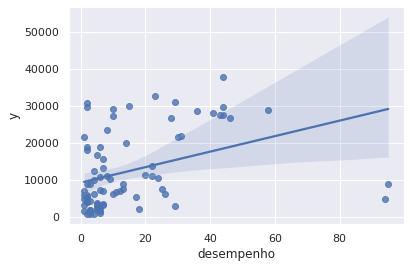

In [50]:
sns.regplot(x=df_desempenho_pais_total['desempenho'], y=(df_desempenho_pais_total['y']))
plt.show()

### Clustering Coefficient X Desempenho 

In [51]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [52]:
model = smf.ols(data=df_desempenho_cluster, formula='(desempenho) ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     76.50
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           3.70e-13
Time:                        01:28:38   Log-Likelihood:                -315.74
No. Observations:                  79   AIC:                             635.5
Df Residuals:                      77   BIC:                             640.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     86.8938      8.360     10.394      0.000      70.247     103.540
c            -88.2099     10.085     -8.746      0.000    -108.292     -68.128
==============================================================================
Omnibus:                       49.726   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.275
Skew:                           1.924   Prob(JB):                     9.79e-46
Kurtosis:                       9.940   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

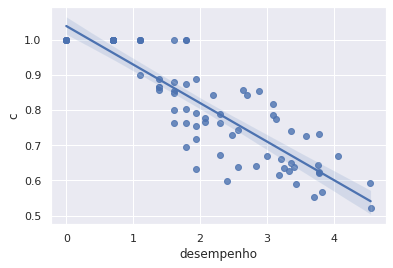

In [53]:
sns.regplot(x=np.log(df_desempenho_cluster['desempenho']), y=df_desempenho_cluster['c'])
plt.show()

### Clustering Coefficient X Desempenho após filtragem


In [54]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<80]

In [55]:
df_desempenho_cluster = df_desempenho_pais_filtered.dropna(subset=['clustering coefficient'])

In [56]:
model = smf.ols(data=df_desempenho_cluster, formula='np.log(desempenho) ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(desempenho)   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     211.3
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.62e-23
Time:                        01:28:39   Log-Likelihood:                -66.810
No. Observations:                  77   AIC:                             137.6
Df Residuals:                      75   BIC:                             142.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4766      0.384     19.468      0.000       6.712       8.242
c             -6.6879      0.460    -14.537      0.000      -7.604      -5.771
==============================================================================
Omnibus:                        1.230   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                1.270
Skew:                           0.227   Prob(JB):                        0.530
Kurtosis:                       2.565   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

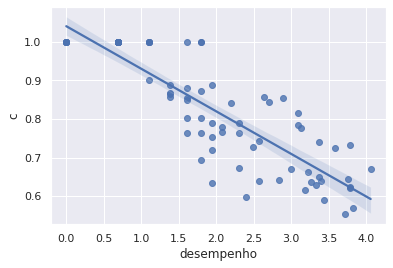

In [57]:
sns.regplot(x=np.log(df_desempenho_cluster['desempenho']), y=df_desempenho_cluster['c'])
plt.show()

In [58]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     53.64
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           2.00e-18
Time:                        01:28:40   Log-Likelihood:                -265.63
No. Observations:                  77   AIC:                             539.3
Df Residuals:                      73   BIC:                             548.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.9461      6.105      8.672      0.000      40.778      65.114
y              0.0005   9.33e-05      5.647      0.000       0.000       0.001
c            -56.7383      6.637     -8.549      0.000     -69.965     -43.512
pop        -5.699e-10   7.11e-09     -0.080      0.936   -1.47e-08    1.36e-08
==============================================================================
Omnibus:                        7.542   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.297
Skew:                           0.575   Prob(JB):                       0.0260
Kurtosis:                       3.977   Cond. No.                     1.36e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Análise período TOTAL

### Carrega dados
---

In [59]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [60]:
#junta ambas as tabelas
df_merge_original=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge_original=df_merge_original.dropna(subset=['region'])

In [61]:
#filtra somente datas posteriores a 1970
df_merge_before=df_merge_original[df_merge_original["Year"] >= 1970]

### Análise
---

In [62]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [63]:
df_merge_before['desempenho'] = df_merge_before['Medal'].apply(lambda x: desempenho(x))

#dropa valores duplicados
df_desempenho = df_merge_before.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])


In [64]:
df_desempenho_pais.head()

,Sport,region,desempenho,media,Country,GDP ($ per capita)
0,Alpine Skiing,Australia,1,1.857143,Australia,29000.0
1,Alpine Skiing,Austria,3,1.857143,Austria,30000.0
2,Alpine Skiing,Czech Republic,1,1.857143,Czech Republic,15700.0
3,Alpine Skiing,France,2,1.857143,France,27600.0
4,Alpine Skiing,New Zealand,2,1.857143,New Zealand,21600.0


In [65]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

lista_vertices = lista_teams+lista_eventos

#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

create_edgs_links(lista_arestas, g)

número de vértices de g: 148


### Análise 2
---

In [66]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

cria_nome_times(g, c) #cria vertíces

dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [67]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

save_gt(c, 'exemplo_c.net.gz')

r = netpixi.render('./exemplo_c.net.gz', infinite=True)

In [68]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x05445E, size=15)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0xB1D4E0, width=1, curve1=0, curve2=0)

r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)




### Cluster coefficient
---

In [69]:
cluster = clustering.local_clustering(c)

c.vp['clustering coefficient'] = cluster

dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [70]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)
        
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

save_gt(g, 'exemplo.net.gz')

r = netpixi.render('./exemplo.net.gz')

In [71]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

r.graph(kscale=0.5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Regressão
---

### GDP X Desempenho

In [72]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()


In [73]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")


In [74]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")


In [75]:
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","Population"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']
df_desempenho_pais_total['pop'] = df_desempenho_pais_total['Population']

In [76]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     17.99
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           5.33e-05
Time:                        01:28:44   Log-Likelihood:                -459.55
No. Observations:                  93   AIC:                             923.1
Df Residuals:                      91   BIC:                             928.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1337      5.308      1.344      0.182      -3.410      17.678
y              0.0015      0.000      4.241      0.000       0.001       0.002
==============================================================================
Omnibus:                      112.319   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2196.977
Skew:                           3.948   Prob(JB):                         0.00
Kurtosis:                      25.464   Cond. No.                     2.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

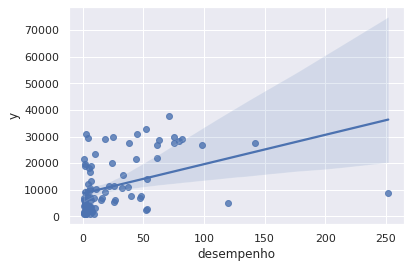

In [77]:
sns.regplot(x=df_desempenho_pais_total['desempenho'], y=(df_desempenho_pais_total['y']))
plt.show()

### GDP X Desempenho após filtragem

In [78]:
df_desempenho_pais_total[df_desempenho_pais_total['desempenho']>60]

,region,desempenho,Country_x,GDP ($ per capita),nome,_x,_y,clustering coefficient,Country_y,Population,y,c,pop
3,Australia,82,Australia,29000.0,Australia,10.829744,2.019719,0.679000,Australia,2.026408e+07,29000.0,0.679000,2.026408e+07
12,Canada,75,Canada,29800.0,Canada,11.032480,3.736130,0.756942,Canada,3.309893e+07,29800.0,0.756942,3.309893e+07
14,China,120,China,5000.0,China,10.821798,2.835206,0.635322,China,1.313974e+09,5000.0,0.635322,1.313974e+09
26,France,75,France,27600.0,France,9.376881,4.076973,0.679974,France,6.087614e+07,27600.0,0.679974,6.087614e+07
29,Germany,142,Germany,27600.0,Germany,8.691829,3.718490,0.551660,Germany,8.242230e+07,27600.0,0.551660,8.242230e+07
42,Italy,98,Italy,26700.0,Italy,8.096524,3.995751,0.617784,Italy,5.813351e+07,26700.0,0.617784,5.813351e+07
45,Japan,79,Japan,28200.0,Japan,7.580042,3.029302,0.633642,Japan,1.274636e+08,28200.0,0.633642,1.274636e+08
61,Netherlands,63,Netherlands,28600.0,Netherlands,9.983316,1.743488,0.764706,Netherlands,1.649146e+07,28600.0,0.764706,1.649146e+07
66,Norway,71,Norway,37800.0,Norway,11.050938,4.455228,0.744580,Norway,4.610820e+06,37800.0,0.744580,4.610820e+06
75,Russia,252,Russia,8900.0,Russia,8.336804,3.106256,0.571917,Russia,1.428935e+08,8900.0,0.571917,1.428935e+08


In [79]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<60]


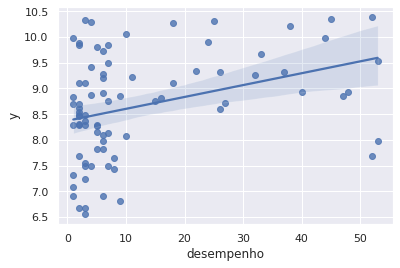

In [80]:
sns.regplot(x=df_desempenho_pais_filtered['desempenho'], y=np.log(df_desempenho_pais_filtered['y']))
plt.show()

In [81]:
model = smf.ols(data=df_desempenho_pais_filtered, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     10.52
Date:                Sat, 27 Nov 2021   Prob (F-statistic):            0.00173
Time:                        01:28:45   Log-Likelihood:                -330.95
No. Observations:                  81   AIC:                             665.9
Df Residuals:                      79   BIC:                             670.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2318      2.372      3.049      0.003       2.510      11.953
y              0.0006      0.000      3.243      0.002       0.000       0.001
==============================================================================
Omnibus:                       24.748   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.203
Skew:                           1.407   Prob(JB):                     3.74e-08
Kurtosis:                       4.489   Cond. No.                     1.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Clustering Coefficient X Desempenho 

In [82]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [83]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     104.2
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.34e-16
Time:                        01:28:45   Log-Likelihood:                -418.58
No. Observations:                  90   AIC:                             841.2
Df Residuals:                      88   BIC:                             846.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    202.6792     17.649     11.484      0.000     167.606     237.752
c           -207.2944     20.306    -10.208      0.000    -247.648    -166.940
==============================================================================
Omnibus:                       93.926   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1550.754
Skew:                           3.129   Prob(JB):                         0.00
Kurtosis:                      22.349   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

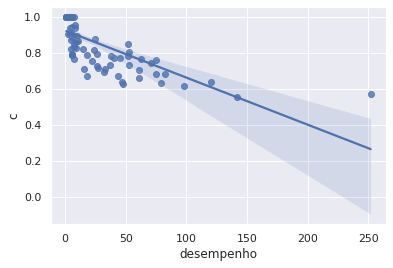

In [84]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

### Clustering Coefficient X Desempenho após filtragem

In [85]:
df_desempenho_cluster = df_desempenho_pais_filtered.dropna(subset=['clustering coefficient'])

In [86]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     103.1
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           8.52e-16
Time:                        01:28:46   Log-Likelihood:                -290.71
No. Observations:                  78   AIC:                             585.4
Df Residuals:                      76   BIC:                             590.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.0495      9.011     11.547      0.000      86.102     121.997
c           -102.1254     10.058    -10.153      0.000    -122.159     -82.092
==============================================================================
Omnibus:                       19.928   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.490
Skew:                           1.004   Prob(JB):                     1.45e-07
Kurtosis:                       5.378   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

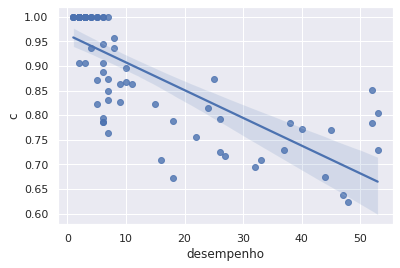

In [87]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

In [88]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c+pop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     41.45
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           7.95e-16
Time:                        01:28:47   Log-Likelihood:                -285.68
No. Observations:                  78   AIC:                             579.4
Df Residuals:                      74   BIC:                             588.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     95.3239      8.993     10.600      0.000      77.405     113.243
y              0.0004      0.000      3.188      0.002       0.000       0.001
c            -96.8366      9.724     -9.958      0.000    -116.212     -77.461
pop         4.646e-09   8.71e-09      0.533      0.595   -1.27e-08     2.2e-08
==============================================================================
Omnibus:                       20.495   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.998
Skew:                           1.042   Prob(JB):                     1.13e-07
Kurtosis:                       5.346   Cond. No.                     1.62e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

___